# **Face Shape Classification Model Using Self-tuning On Fine-tuned Networks** <br>


**1Team Member** : Yungbeom Park(Team Leader), Yejin Kim, Seunghyun Kwan, Hojun Kim, Sangjoon Choi <br>
**1Team Github** : https://github.com/1team1768/1team.git<br><br>
**Dataset** : LFW-5590, SCUT-FBP5500_v2.1(Faceshape labels were made by 1Team)<br><br>
**Reference** <br> David_Lee's_Science.log<br>  https://www.tensorflow.org/tutorials/load_data/images?hl=ko<br> Unsupervised feature learning for self-tuning neural networks Jongbin Ryu, Ming-Hsuan Yang, Jongwoo Lim(2021)

## **1. Import DataSet**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import pathlib

In [4]:
data_dir = "/content/drive/MyDrive/Faceshape_project/facetype"
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1535


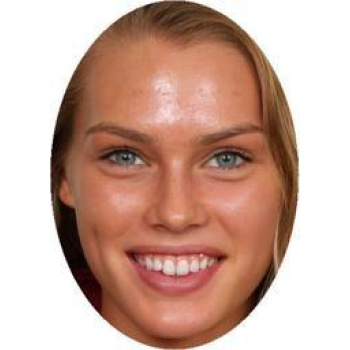

In [6]:
long = list(data_dir.glob('long/*'))
PIL.Image.open(str(long[0]))

## **2. Data Preprocessing**

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1535 files belonging to 5 classes.
Using 1228 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1535 files belonging to 5 classes.
Using 307 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['angulate', 'circle', 'egg', 'long', 'triangle']


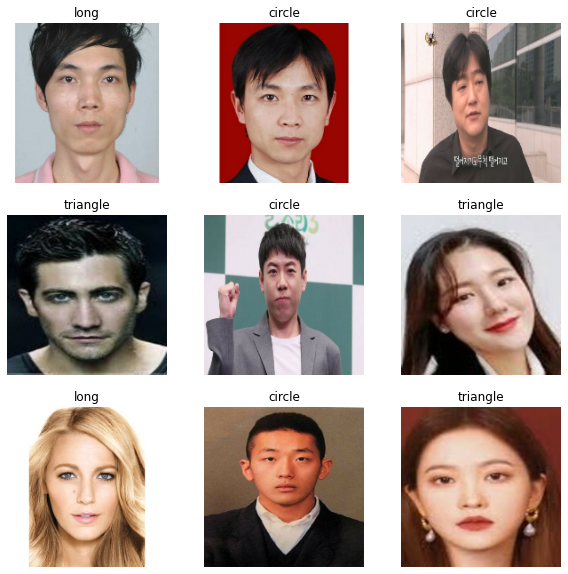

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Transfer Learning**
<p>base model: Resnet50

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

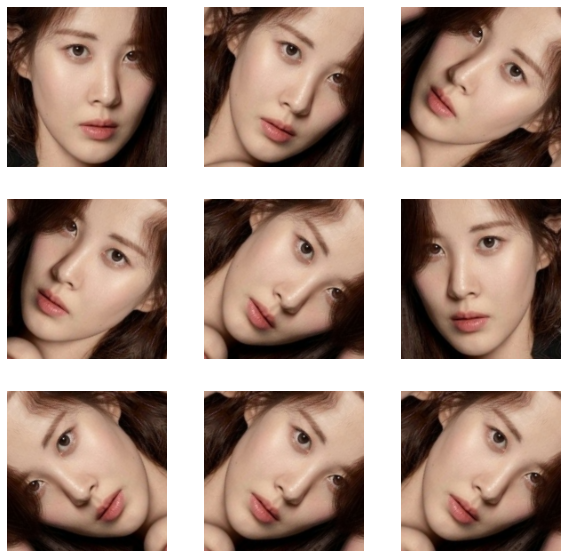

In [18]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization


base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (180,180 ,3), weights = 'imagenet')
base_model.trainable = False

# input_y = tf.keras.utils.to_categorical(train_ds, 5)
# test_y = tf.keras.utils.to_categorical(val_ds, 5)

# 모델 layer 설계
inputs = tf.keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = tf.keras.layers.experimental.preprocessing.Resizing(180, 180)(x)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(5, activation = 'softmax')(x)
model_res = tf.keras.Model(inputs, outputs)


94781440/94765736 [==============================] - 1s 0us/step


In [20]:
model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 resizing (Resizing)         (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                             

In [21]:
model_res.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_res.fit(train_ds,validation_data=val_ds, epochs=10, callbacks=[early])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 157s 4s/step - loss: 1.2485 - accuracy: 0.4829 - val_loss: 0.9372 - val_accuracy: 0.6287
Epoch 2/10
39/39 [==============================] - 3s 86ms/step - loss: 0.7981 - accuracy: 0.6865 - val_loss: 0.8071 - val_accuracy: 0.6775
Epoch 3/10
39/39 [==============================] - 3s 87ms/step - loss: 0.6842 - accuracy: 0.7191 - val_loss: 0.7452 - val_accuracy: 0.7003
Epoch 4/10
39/39 [==============================] - 3s 87ms/step - loss: 0.6678 - accuracy: 0.7199 - val_loss: 0.6952 - val_accuracy: 0.7101
Epoch 5/10
39/39 [==============================] - 3s 87ms/step - loss: 0.6249 - accuracy: 0.7565 - val_loss: 0.6578 - val_accuracy: 0.7199
Epoch 6/10
39/39 [==============================] - 3s 87ms/step - loss: 0.5776 - accuracy: 0.7459 - val_loss: 0.6687 - val_accuracy: 0.7166
Epoch 7/10
39/39 [==============================] - 3s 87ms/step - loss: 0.5704 - accuracy: 0.7695 - val_loss: 0.6323 - val_accuracy: 0.7134
Epoch 8/10
39/39 [======

### 3.1 evaluate transfer model

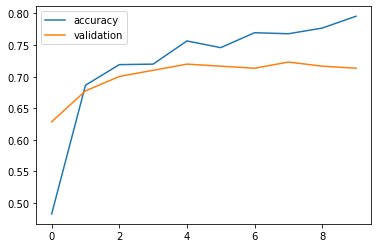

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

In [23]:
loss, acc = model_res.evaluate(val_ds,verbose=2)

10/10 - 1s - loss: 0.6536 - accuracy: 0.7134 - 705ms/epoch - 71ms/step


In [24]:
 model_res.save('/content/drive/MyDrive/Faceshape_project/transfer7134.h5')

## **4. Fine-Tuning**

In [40]:
# model_res = tf.keras.models.load_model('/content/drive/MyDrive/Faceshape_project/transfer7557.h5')

In [25]:
base_model.trainable = True		# resnet 모델 학습동결을 해제한다
for i in base_model.layers[:143]:	# 143층부터의 학습은 해제상태로 두고, 
  i.trainable = False				# 이전까지의 학습은 동결한다.
  
for i in base_model.layers[140:]:	# 동결이 제대로 해제됐는지 약간 이전층부터 출력해본다.
  print(i.name, i.trainable)


conv4_block6_3_bn False
conv4_block6_add False
conv4_block6_out False
conv5_block1_1_conv True
conv5_block1_1_bn True
conv5_block1_1_relu True
conv5_block1_2_conv True
conv5_block1_2_bn True
conv5_block1_2_relu True
conv5_block1_0_conv True
conv5_block1_3_conv True
conv5_block1_0_bn True
conv5_block1_3_bn True
conv5_block1_add True
conv5_block1_out True
conv5_block2_1_conv True
conv5_block2_1_bn True
conv5_block2_1_relu True
conv5_block2_2_conv True
conv5_block2_2_bn True
conv5_block2_2_relu True
conv5_block2_3_conv True
conv5_block2_3_bn True
conv5_block2_add True
conv5_block2_out True
conv5_block3_1_conv True
conv5_block3_1_bn True
conv5_block3_1_relu True
conv5_block3_2_conv True
conv5_block3_2_bn True
conv5_block3_2_relu True
conv5_block3_3_conv True
conv5_block3_3_bn True
conv5_block3_add True
conv5_block3_out True
avg_pool True


In [26]:
model_res.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 resizing (Resizing)         (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                             

In [27]:
save_fine = model_res.fit(train_ds, validation_data = val_ds, epochs=20, initial_epoch = history.epoch[-1])

Epoch 10/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 10s 142ms/step - loss: 3.5133 - accuracy: 0.4235 - val_loss: 0.9053 - val_accuracy: 0.5798
Epoch 11/20
39/39 [==============================] - 4s 112ms/step - loss: 0.7652 - accuracy: 0.6775 - val_loss: 0.6917 - val_accuracy: 0.6808
Epoch 12/20
39/39 [==============================] - 4s 112ms/step - loss: 0.6616 - accuracy: 0.7085 - val_loss: 0.6409 - val_accuracy: 0.7166
Epoch 13/20
39/39 [==============================] - 4s 112ms/step - loss: 0.5867 - accuracy: 0.7370 - val_loss: 0.7736 - val_accuracy: 0.6645
Epoch 14/20
39/39 [==============================] - 4s 113ms/step - loss: 0.6939 - accuracy: 0.6995 - val_loss: 0.6884 - val_accuracy: 0.6710
Epoch 15/20
39/39 [==============================] - 4s 113ms/step - loss: 0.5573 - accuracy: 0.7427 - val_loss: 0.6270 - val_accuracy: 0.7362
Epoch 16/20
39/39 [==============================] - 4s 113ms/step - loss: 0.5090 - accuracy: 0.7769 - val_loss: 0.5879 - val_accuracy: 0.7329
Epoch 17/2

### 4.1 evaluate fine-tuned model

In [31]:
model_res.save('/content/drive/MyDrive/Faceshape_project/fine_mode7296.h5')

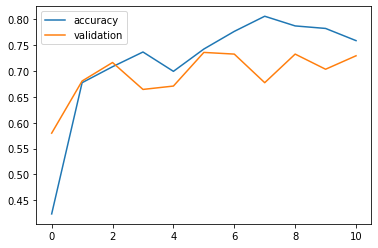

In [29]:
plt.plot(save_fine.history['accuracy'])
plt.plot(save_fine.history['val_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

In [30]:
loss, acc = model_res.evaluate(val_ds,verbose=2)

10/10 - 1s - loss: 0.5820 - accuracy: 0.7296 - 712ms/epoch - 71ms/step



**val accuracy: 0.71(transfer) -> 0.73(fine)**

## **5. Self-Tuning on Fine-Tuned Model**

### 5.0 make preprocessing self-tuning data function and self-tunig dataset

In [33]:
s_dir = "/content/drive/MyDrive/Faceshape_project/train/lfw_5590"

In [34]:
s_dir = pathlib.Path(s_dir)

In [35]:
image_count = len(list(s_dir.glob('*.jpg')))
print(image_count)

5590


In [36]:
pseudo_feature = tf.keras.preprocessing.image_dataset_from_directory(
  s_dir,
  labels=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5590 files belonging to 1 classes.


In [37]:
normalized_ds = pseudo_feature.map(lambda x: (normalization_layer(x)))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99074095


In [38]:
AUTOTUNE = tf.data.AUTOTUNE

pseudo_data = pseudo_feature.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
len(pseudo_data)

175

In [40]:
def pseudo_pro(feature,s_cycle):

    accuracy_list = []


    for i in range(len(s_cycle)):
        id = np.argmax(s_cycle[i])
        accuracy_list.append(id)
    

    pseudo_label = tf.convert_to_tensor(accuracy_list)

    pse_feature = feature.unbatch()
    pse_feature = list(pse_feature)

    pseudo_prepro = tf.data.Dataset.from_tensor_slices(
    (pse_feature, pseudo_label)).shuffle(10000).batch(32)

    AUTOTUNE = tf.data.AUTOTUNE
    pseudo_prepro = pseudo_prepro.cache().prefetch(buffer_size=AUTOTUNE)

    return pseudo_prepro



### 5.1 self-tuning cycle1

In [48]:
copy_model = tf.keras.models.load_model('/content/drive/MyDrive/Faceshape_project/fine_mode7296.h5')

In [49]:
copy_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 resizing (Resizing)         (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                             

In [41]:
s_cycle1 = copy_model.predict(pseudo_data)

In [42]:
pseudo_dataset = pseudo_pro(pseudo_data, s_cycle1)
pseudo_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [43]:
combined_dataset = train_ds.concatenate(pseudo_dataset).shuffle(10000)

In [44]:
combined_dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [50]:
student_history = copy_model.fit(combined_dataset,validation_data=val_ds,epochs=4)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


214/214 [==============================] - 27s 104ms/step - loss: 0.1779 - accuracy: 0.9380 - val_loss: 0.5033 - val_accuracy: 0.7394
Epoch 2/4
214/214 [==============================] - 22s 101ms/step - loss: 0.1478 - accuracy: 0.9431 - val_loss: 0.5553 - val_accuracy: 0.7557
Epoch 3/4
214/214 [==============================] - 22s 102ms/step - loss: 0.1706 - accuracy: 0.9361 - val_loss: 0.7237 - val_accuracy: 0.6873
Epoch 4/4
214/214 [==============================] - 22s 102ms/step - loss: 0.1814 - accuracy: 0.9372 - val_loss: 0.5830 - val_accuracy: 0.7134


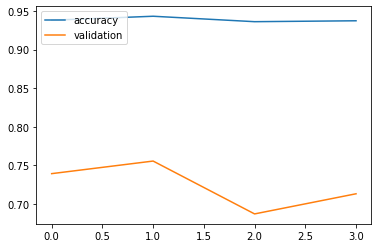

In [51]:
import matplotlib.pyplot as plt

plt.plot(student_history.history['accuracy'])
plt.plot(student_history.history['val_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

In [52]:
loss, acc = copy_model.evaluate(val_ds,verbose=2)

10/10 - 1s - loss: 0.5830 - accuracy: 0.7134 - 739ms/epoch - 74ms/step


self-tuning cycle1 result: **0.7557(fine-tuned) -> 0.7720(self-tuned cycle1)**

In [ ]:
# -- 절취선 --

### 5.2 self-tuning cycle2

In [53]:
s_cycle2 = copy_model.predict(pseudo_data)

In [54]:
pseudo_dataset2 = pseudo_pro(pseudo_data, s_cycle2)
pseudo_dataset2

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [55]:
combined_dataset = train_ds.concatenate(pseudo_dataset2).shuffle(10000)

In [56]:
student_model1 = tf.keras.models.load_model('/content/drive/MyDrive/Faceshape_project/fine_mode7296.h5')

In [57]:
student_model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 resizing (Resizing)         (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                             

In [58]:
student_history2 = student_model1.fit(combined_dataset,validation_data=val_ds, epochs=4)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


214/214 [==============================] - 27s 104ms/step - loss: 0.1696 - accuracy: 0.9405 - val_loss: 0.7198 - val_accuracy: 0.6971
Epoch 2/4
214/214 [==============================] - 21s 100ms/step - loss: 0.8660 - accuracy: 0.8956 - val_loss: 3.5253 - val_accuracy: 0.1824
Epoch 3/4
214/214 [==============================] - 22s 101ms/step - loss: 0.4553 - accuracy: 0.8893 - val_loss: 0.8843 - val_accuracy: 0.6287
Epoch 4/4
214/214 [==============================] - 22s 102ms/step - loss: 0.1615 - accuracy: 0.9403 - val_loss: 0.6847 - val_accuracy: 0.6775


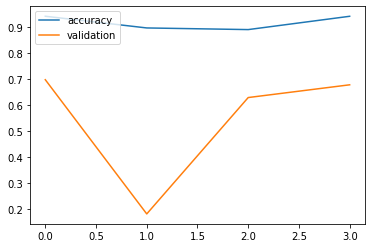

In [59]:
import matplotlib.pyplot as plt

plt.plot(student_history2.history['accuracy'])
plt.plot(student_history2.history['val_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

### 5.3 self-tuning cycle3

In [60]:
s_cycle3 = student_model1.predict(pseudo_data)

In [61]:
pseudo_dataset3 = pseudo_pro(pseudo_data, s_cycle3)
pseudo_dataset3

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [62]:
combined_dataset = train_ds.concatenate(pseudo_dataset3).shuffle(10000)

In [63]:
student_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Faceshape_project/fine_mode7296.h5')

In [64]:
student_history2 = student_model2.fit(combined_dataset,validation_data=val_ds, epochs=4)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


214/214 [==============================] - 27s 106ms/step - loss: 0.7446 - accuracy: 0.8749 - val_loss: 4.8121 - val_accuracy: 0.2736
Epoch 2/4
214/214 [==============================] - 21s 100ms/step - loss: 0.1947 - accuracy: 0.9315 - val_loss: 0.6619 - val_accuracy: 0.6840
Epoch 3/4
214/214 [==============================] - 22s 101ms/step - loss: 0.1500 - accuracy: 0.9421 - val_loss: 0.6399 - val_accuracy: 0.7264
Epoch 4/4
214/214 [==============================] - 22s 102ms/step - loss: 0.1070 - accuracy: 0.9528 - val_loss: 0.5732 - val_accuracy: 0.7427


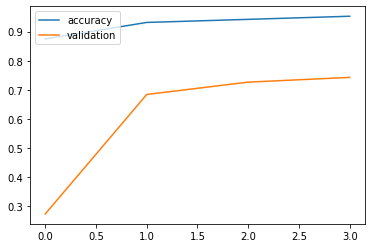

In [66]:
import matplotlib.pyplot as plt

plt.plot(student_history2.history['accuracy'])
plt.plot(student_history2.history['val_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

self-tuning 결과 **0.7296(fine-tuning) -> 0.7427(self-tunig 3cycle)**

### 5.4 self-tunung cycle4

Our team could not run the program due to a lack of GPU and memory.

## **6. Discussion**

우리팀은 Unsupervised feature learning for self-tuning neural networks Jongbin Ryu, Ming-Hsuan Yang, Jongwoo Lim(2021)에 소개 된 self-tuning on fine-tuned networks을 통하여 얼굴형 분류 모델을 설계하고, 정확도를 상승시키기 위해 다음과 같은 프로세스를 진행하였다.<br>
<br>
Reset-50 모델을 베이스모델로 Transfer-learning과 Fine-tuning을 진행하였다.<br>
그 결과 정확도가 **Transfer-learning: 0.71 -> Fine-tuning: 0.73**으로 상승하였다.
<br>
<br>또한 Pseudo-Label : The Simple and Efficient Semi-Supervised Learning
Method for Deep Neural Networks(2013)에 소개된 pseudo-labeling 알고리즘을 통해 self-tuning을 진행하였다.
<br>
<br>그 결과 정화도가 **Fine-tuning: 0.73 -> Self-tuning: 0.74**으로 상승하였다.


## **Future Plans**

우리팀은 데이터셋을 추가하여 총 3000개의 FaceShape dataset구축을 목표로하고있다.
<br> 또한 Resnet-50뿐만 아니라 Alexnet,VGG-19,Efficientnet등 다양한 모델을 활용하여 self-tuning on fine-tuned networks을 진행할것이다.<br>
결과에 따라 해당 모델들의 정확도를 비교하여 가장 정확도가 높은 모델을 얼굴형별 안경추천과 웹사이트를 구축할것이다.<br>
마지막으로 해당 프로젝트에서 사용된 F-A 딥러닝 모델과 기존의 SVM모델을 비교하여 딥러닝 모델의 사용이 유의한지 검토할것이다.